<!--HEADER-->
[*Notas sobre modelagem da epidemia de Covid-19*](https://github.com/rmsrosa/modcovid19) / [*IM-UFRJ*](https://www.im.ufrj.br).

# O cenário da cidade do Rio de Janeiro: rede escolar

- Continuando a criação de cenários que sejam **múltiplos** do cenário `Pop350` visto anteriormente.

- Neste segundo caderno da série, ...

In [1]:
import datetime # date and time tools

import os, sys

import math

import random

import numpy as np
from scipy import stats
from scipy.interpolate import interp2d

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

import io, base64
from IPython.display import Image, HTML

import pandas as pd

import rede_escolar

In [2]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../../..')))
import episiming

In [3]:
sns.set_style("darkgrid")

In [4]:
dt_string = datetime.datetime.now().strftime("%d/%b/%Y")
print(f"Atualização mais recente do kernel: {dt_string}")

Atualização mais recente do kernel: 09/Jul/2020


## Distribuição populacional da cidade do Rio de Janeiro

Primeiramente, conforme feito anteriormente:

- posicionamos as residências;

- distribuímos os indivíduos em suas residências; e 

- posicionamos os indivíduos em torno de suas residências.

### Carregando os dados

Carregamos os dados populacionais por quilômetro quadrado da cidade do Rio de Janeiro obtidos do [Landscan](https://landscan.ornl.gov), mudando para 0 o valor das células com -1.

In [5]:
landscan_rio = np.load('../../../../dados/RJ/cidade_rj/dados_estatisticos/LandScan.npy').astype(int)
landscan_rio = np.maximum(landscan_rio, 0)

Carregamos os dados de escolas por quilômetro quadrado da cidade do Rio de Janeiro, obtidos do [IPP/Data Rio](https://www.data.rio/datasets/escolas-municipais)

In [6]:
escolas_municipais = np.load('../../../../dados/RJ/cidade_rj/dados_estatisticos/Municipais.npy').astype(int)

### Visualização em escala logarítmica

Visualizamos 

$$ ln( 1 + \textrm{população})
$$

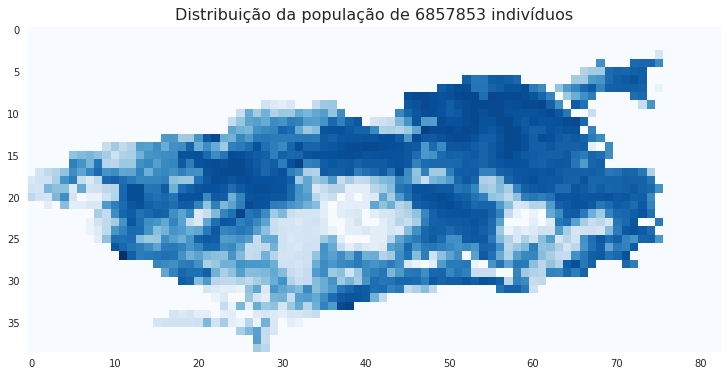

In [7]:
plt.figure(figsize=(16,6))
plt.imshow(np.log(1 + landscan_rio), cmap='Blues', interpolation='none')
plt.grid(False)
plt.title(f'Distribuição da população de {int(landscan_rio.sum())} indivíduos', fontsize=16)
plt.show()

In [8]:
plt.figure(figsize=(16,6))
plt.imshow(np.log(1 + refina_matriz(landscan_rio,bairros_fino)[0]), cmap='Blues', interpolation='none')
plt.grid(False)
plt.title(f'Distribuição da população de {int(landscan_rio.sum())} indivíduos', fontsize=16)
plt.show()

NameError: name 'refina_matriz' is not defined

<Figure size 1152x432 with 0 Axes>

In [9]:
bairros_fino = np.load('geoloc_Bairros_MRJ_Fino.npy')

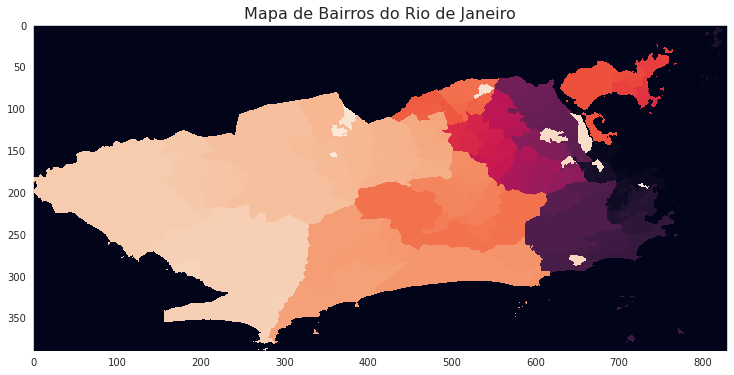

In [10]:
plt.figure(figsize=(16,6))
plt.imshow(bairros_fino, interpolation='none')
plt.grid(False)
plt.title(f'Mapa de Bairros do Rio de Janeiro', fontsize=16)
plt.show()

In [11]:
def refina_matriz(matriz, filtro):
    '''
    Refina uma matriz via interpolação linear e uma matriz fina como filtro.  
    '''
    matriz_fina = np.zeros_like(filtro)
    loc_sobra = list() 
    
    tx_refinamento_x = int(filtro.shape[1]/matriz.shape[1])
    tx_refinamento_y = int(filtro.shape[0]/matriz.shape[0])
    xs = list(range(matriz.shape[1]))
    ys = list(range(matriz.shape[0]))

    xs_fino = np.arange(0, matriz.shape[1], 1/tx_refinamento_x)
    ys_fino = np.arange(0, matriz.shape[0], 1/tx_refinamento_y)

    f = interp2d(xs, ys, matriz, kind='linear')
    matriz_interp = f(xs_fino, ys_fino)*np.minimum(filtro,1)

    for j in xs:
        for i in ys:
            if matriz[i,j]:
                matriz_interp_local \
                    = matriz_interp[i*tx_refinamento_y:(i+1)*tx_refinamento_y,
                                    j*tx_refinamento_x:(j+1)*tx_refinamento_x]
                if matriz_interp_local.sum() == 0:
                    loc_sobra.append([i,j])
                else:
                    distrib = np.floor(matriz[i,j]*matriz_interp_local
                                           / matriz_interp_local.sum()
                                      ).astype('int')
                    sobra = matriz[i,j] - distrib.sum()
                    sobra_posicionamento \
                        = np.random.choice(tx_refinamento_x*tx_refinamento_y,
                                           int(sobra),
                                           replace=False,
                                           p=(matriz_interp_local
                                              /matriz_interp_local.sum()
                                             ).flatten()
                                          )
                    for loc in sobra_posicionamento:
                        distrib[loc // tx_refinamento_x,
                                loc % tx_refinamento_x] += 1
                    matriz_fina[i*tx_refinamento_y:(i+1)*tx_refinamento_y,
                                j*tx_refinamento_x:(j+1)*tx_refinamento_x] \
                        = distrib

    matriz_sobra = np.zeros_like(matriz)
    for ij in loc_sobra:
        matriz_sobra[ij[0], ij[1]] = matriz[ij[0], ij[1]]
    
    return matriz_fina, matriz_sobra

Carregando as matrizes das escolas

In [12]:
modalidades = [2,3,5,6,7,15,21,30,35,42,105,210]
escolas_pub = [np.load(f'mtrx_escolas/escolas_publicas_{m}.npy') for m in modalidades]
escolas_prv = [np.load(f'mtrx_escolas/escolas_privadas_{m}.npy') for m in modalidades]

Fazendo a interpolação para o refinamento da malha

In [13]:
mtrx_escolas_pub = np.array([refina_matriz(i, bairros_fino)[0] for i in escolas_pub])
mtrx_escolas_prv = np.array([refina_matriz(i, bairros_fino)[0] for i in escolas_prv])

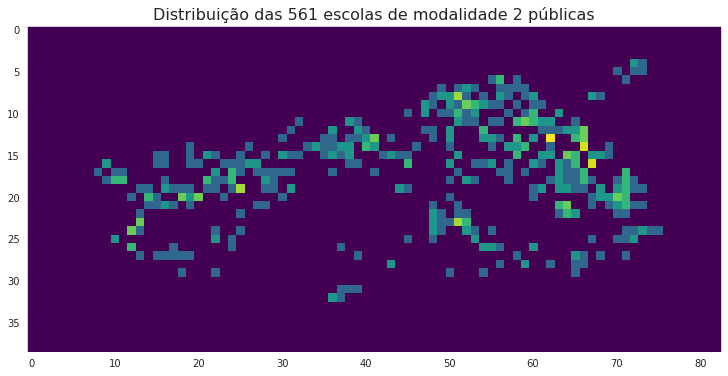

In [14]:
plt.figure(figsize=(16,6))
plt.imshow(np.log(1 + escolas_pub[0]), cmap='viridis', interpolation='none')
plt.grid(False)
plt.title(f'Distribuição das {int(mtrx_escolas_pub[0].sum())} escolas de modalidade {modalidades[0]} públicas', fontsize=16)
plt.show()

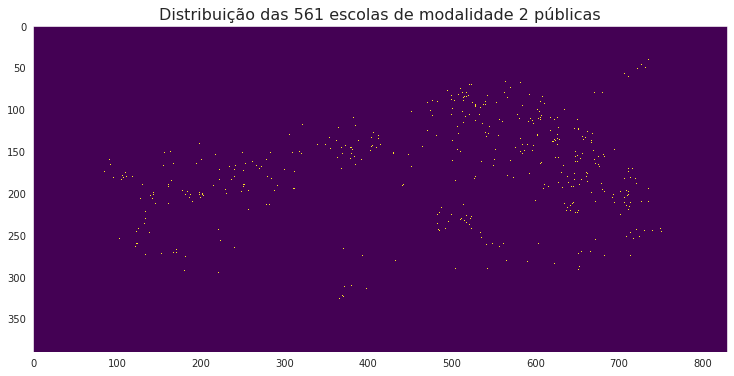

In [15]:
plt.figure(figsize=(16,6))
plt.imshow(np.log(1 + mtrx_escolas_pub[0]), cmap='viridis', interpolation='none')
plt.grid(False)
plt.title(f'Distribuição das {int(mtrx_escolas_pub[0].sum())} escolas de modalidade {modalidades[0]} públicas', fontsize=16)
plt.show()

## Rede residencial

Montamos a rede residencial como antes.

O importante para a montagem da rede de empresas não é a rede residencial em si, apenas a localização dos indivíduos feita na construção da rede residencial.

### Reduzindo a população

Com o objetivo de realizar testes mais rápidos, com populações menores, dividimos a população de cada bloco por um determinado fator. 

Essa divisão nos dá números em ponto flutuante, que então truncamos para a sua parte inteira.

In [24]:
censo_residencial = np.array([.21, .26, .20, .17, .08, .04, .02, 0.02])
pop_por_blocos = (landscan_rio/100).astype(int)

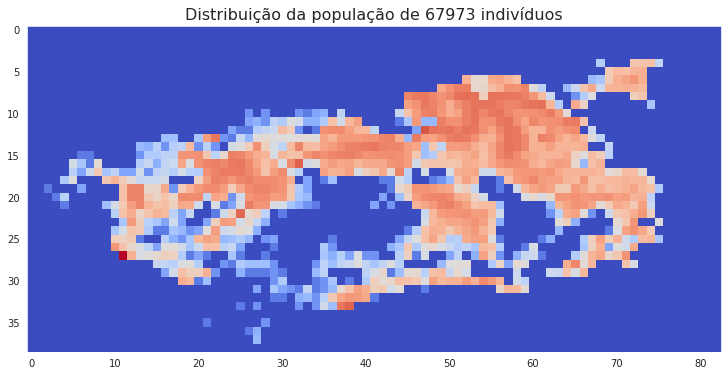

In [25]:
plt.figure(figsize=(16,6))
plt.imshow(np.log(1 + pop_por_blocos), cmap='coolwarm', interpolation='none')
#plt.colorbar()
plt.grid(False)
plt.title(f'Distribuição da população de {pop_por_blocos.sum()} indivíduos', fontsize=16)
plt.show()

### Distribuindo e alocando os indivíduos e as suas residências

In [26]:
%%time
pos_residencias, pos_individuos, res_individuos, pop_blocos_indices \
    = episiming.cenarios.aloca_residencias_e_individuos(pop_por_blocos, censo_residencial)

CPU times: user 440 ms, sys: 6.48 ms, total: 446 ms
Wall time: 448 ms


In [27]:
pop_blocos_indices[-1]

67973

### Gerando o grafo da rede residencial

In [28]:
%%time
attrib_pos_individuos = {j: pos_individuos[j] for j in range(len(pos_individuos))}

G_r = nx.random_geometric_graph(len(pop_por_blocos), 0, pos=attrib_pos_individuos)

for individuos in res_individuos:
    if len(individuos) > 1:
        G_r.add_edges_from([(i,j) for i in individuos for j in individuos if i < j])

CPU times: user 203 ms, sys: 13.3 ms, total: 216 ms
Wall time: 219 ms


### Viualização

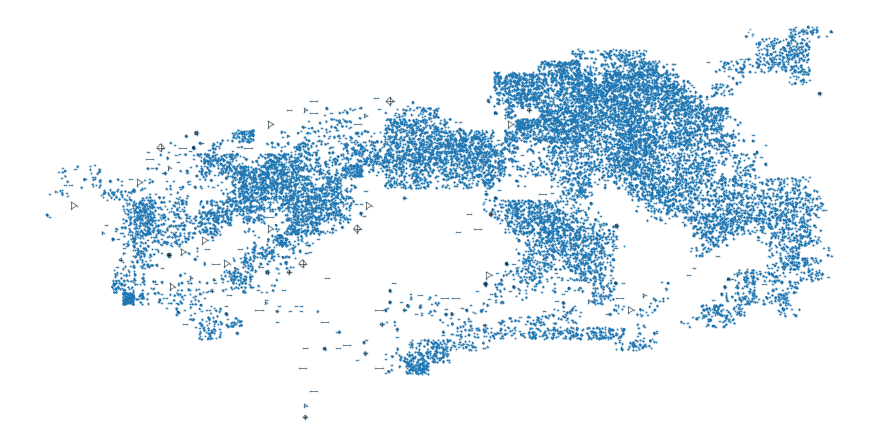

CPU times: user 829 ms, sys: 170 ms, total: 999 ms
Wall time: 701 ms


In [29]:
%%time
plt.figure(figsize=(12,6))
nx.draw(G_r, pos=attrib_pos_individuos, node_size=1, alpha=0.5)
plt.show()

## Rede escolar

Na construção da rede escolar, a ideia é fazer os seguintes passos:

- Temos as distribuições geolocalizadas das escolas.

- A partir do censo de idade populacional, determinar a parte da população a ser alocada nas escolas

- Para alocar a população nas escolas: Calculamos a distância de cada individuo para todas as escolas, e tomamos as 3 escolas mais próximas. Feito isso é selecionao uma das 3 escolas de maneira aleatória

- Para o cenário múltiplo de `Pop350`, fazemos uma redução proporcional no número de escolas com a função `random.choices`

### Redução no número de escolas

Para acompanhar a redução na população, fazemos uma redução proporcional no número de escolas

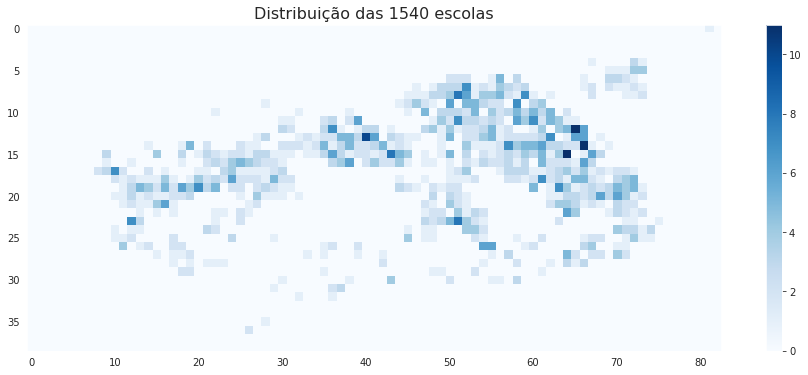

In [30]:
plt.figure(figsize=(16,6))
plt.imshow(escolas_municipais, cmap='Blues', interpolation='none')
plt.colorbar()
plt.grid(False)
plt.title(f'Distribuição das {escolas_municipais.sum()} escolas', fontsize=16)
plt.show()

In [31]:
tx_reducao = 100
esc_escolha, dist_escolas = rede_escolar.distribui_escolas(tx_reducao, escolas_municipais)

In [32]:
escolas = mtrx_escolas_pub + mtrx_escolas_prv

In [33]:
np.sum(escolas)

4070.0

In [34]:
def distribui_escolas(tx_reducao, escolas):
    total_escolas = np.sum(escolas)
    rng_escolas = np.arange(np.prod(np.shape(escolas)))
    weight_escolas = (escolas/np.sum(escolas)).flatten()

    index_escolas = rng_escolas[weight_escolas != 0]  ## Guardando o indice das escolas
    weight_escolas = weight_escolas[weight_escolas != 0]
    esc_escolha = np.array(random.choices(index_escolas, weight_escolas, k = np.round(np.sum(escolas/tx_reducao)).astype(int)))

    row_escolas = np.floor(esc_escolha/830)
    col_escolas = np.mod(esc_escolha,830)
    escolas_escolha_por_blocos = np.zeros((390,830))
    for i,j in zip(row_escolas,col_escolas):
        escolas_escolha_por_blocos[int(i)][j] += 1

    return esc_escolha, escolas_escolha_por_blocos

In [35]:
dist_escola = [distribui_escolas(tx_reducao, escolas[i]) for i in range(12)]

In [36]:
escolha_escolas_reduzidas = [i[0] for i in dist_escola]

In [37]:
mtrx_escolas_reduzidas = [i[1] for i in dist_escola]

In [38]:
escolas[0].flatten()

array([0., 0., 0., ..., 0., 0., 0.])

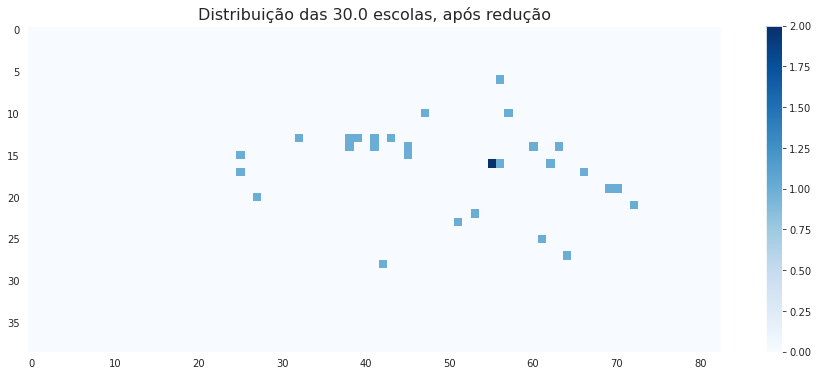

In [39]:
plt.figure(figsize=(16,6))
plt.imshow(dist_escolas, cmap='Blues', interpolation='none')
plt.colorbar()
plt.grid(False)
plt.title(f'Distribuição das {dist_escolas.sum()} escolas, após redução', fontsize=16)
plt.show()

## Distribuição das idades

## Pirâmide etária do rio de Janeiro

- Como as pirâmides etárias do Rio de Janeiro e do Brasil são razoavelmente diferentes, vamos trabalhar com os dados do Rio.

- Inicialmente, consideramos a pirâmide populacional da cidade do Rio de Janeiro disponível na [Tabela do IPP/Data Rio](https://www.data.rio/datasets/popula%C3%A7%C3%A3o-residente-por-grupos-de-idade-e-sexo-segundo-as-%C3%A1reas-de-planejamento-ap-e-regi%C3%B5es-administrativas-ra-no-munic%C3%ADpio-do-rio-de-janeiro-2010)

In [40]:
num_pop = pop_por_blocos.sum()

piramide_etaria = pd.read_csv('../../../../dados/RJ/cidade_rj/dados_estatisticos/piramide_etaria_MRJ.csv')
idades_grupos = np.array([int(p[0:2]) for p in piramide_etaria.columns[1:]])
idades_grupos[-1] = 100
idades_fracoes_grupos = piramide_etaria.iloc[0][1:].values/piramide_etaria.iloc[0][0]

idade_max = 100
pop_idades = episiming.cenarios.gera_idades(67973, 8, res_individuos, idades_grupos, idades_fracoes_grupos, idade_max = 100)

/home/gil/repos/covid19/episiming/cenarios.py:232: RuntimeWarning: divide by zero encountered in double_scalars
  * [idades_fracoes_grupos[-1]/(idade_max-idades_grupos[-1])]


In [41]:
dist_idades_na_escola = rede_escolar.distribuicao_idade(num_pop, censo_residencial, res_individuos, pop_idades, piramide_etaria, idades_grupos, idades_fracoes_grupos, idade_max)

In [42]:
dist_idades_na_escola

array([ 258,  258,  258,  260,  730,  766,  806,  808,  814,  897, 1019,
        962,  972,  961,  952,  815,  788,  786,  794,  523])

In [43]:
def distribuicao_idade(num_pop, censo_residencial, res_individuos, pop_idades, piramide_etaria, idades_grupos, idades_fracoes_grupos, idade_max, tx_reducao):
    num_pop_0a19 = int(num_pop*np.sum(idades_fracoes_grupos[0:20]))

    p_esc_a_idades_grupos = np.array([0, 4, 6, 15, 20, 100])
    p_esc_a_idades_fracoes_grupos = np.array([.33, .92, .97, .80, 0.05])
    num_tam_res = len(censo_residencial)
    distrib_tam_por_res = np.array([len(res_individuos[k]) for k in range(len(res_individuos))])
    distrib_res = np.array([len(distrib_tam_por_res[distrib_tam_por_res == j]) for j in range(1,num_tam_res+1)])

    p_esc_a_idades_fracoes = list()
    for j in range(len(p_esc_a_idades_grupos)-1):
        p_esc_a_idades_fracoes += (p_esc_a_idades_grupos[j+1] - p_esc_a_idades_grupos[j])*[p_esc_a_idades_fracoes_grupos[j]]

    p_esc_a_idades_fracoes = np.array(p_esc_a_idades_fracoes)

    num_ativos_escola = int(p_esc_a_idades_fracoes.sum()/tx_reducao * num_pop)

    pessoas_por_idade = list()

    for idade_escolar in range(20):
        pessoas_por_idade.append(np.count_nonzero(pop_idades == idade_escolar))
    
    pessoas_por_idade = np.array(pessoas_por_idade)
    idades_na_escola_fracoes = p_esc_a_idades_fracoes[:20]
    idades_na_escola = np.round(idades_na_escola_fracoes*pessoas_por_idade).astype(int)
    return idades_na_escola


In [44]:
tx_reducao = 100

In [45]:
distribuicao_idade(num_pop, censo_residencial, res_individuos, pop_idades, piramide_etaria, idades_grupos, idades_fracoes_grupos, idade_max, tx_reducao)

array([ 258,  258,  258,  260,  730,  766,  806,  808,  814,  897, 1019,
        962,  972,  961,  952,  815,  788,  786,  794,  523])

### Escolhendo os alunos

In [46]:
alunos = rede_escolar.escolhe_alunos_idade(pop_idades, dist_idades_na_escola)

In [47]:
def escolhe_alunos_idade(pop_idades, idades_na_escola):
    alunos = [np.random.choice(np.arange(len(pop_idades))[pop_idades == i], idades_na_escola[i], replace = False) for i in range(20)]
    return alunos

## Alocando população escolar nas escolas

### Gerando a localização das escolas

In [48]:
esc_escolha

array([ 887, 1960, 2136, 1270, 1383, 1815, 1203, 1118,  877, 1222, 2305,
       1122, 1290, 1225, 1390, 1687, 1120, 1383, 1879, 1646, 1111, 1200,
        554, 1436, 1117, 1207, 1477, 1384, 2366, 1647])

In [49]:
escolas = rede_escolar.aloca_alunos(alunos, esc_escolha, pos_individuos)

In [50]:
esc_escolha

array([ 887, 1960, 2136, 1270, 1383, 1815, 1203, 1118,  877, 1222, 2305,
       1122, 1290, 1225, 1390, 1687, 1120, 1383, 1879, 1646, 1111, 1200,
        554, 1436, 1117, 1207, 1477, 1384, 2366, 1647])

In [185]:
def aloca_alunos(alunos, escola_escolha, pos_individuos):
    escolas_return = []
    alunos_array = np.hstack(alunos)
    for i in range(len(escola_escolha)):
        row_escolas = np.floor(escola_escolha[i]/830)
        col_escolas = np.mod(escola_escolha[i],830)

        pos_x_escolas = col_escolas + np.random.rand(len(escola_escolha[i]))
        pos_y_escolas = row_escolas + np.random.rand(len(escola_escolha[i]))
        pos_escolas = np.array([pos_x_escolas,pos_y_escolas]).T

        pos_individuos_escolas = np.array(pos_individuos)[alunos_array]
        dist_indiv_esc = [np.linalg.norm(p_i - pos_escolas, axis = 1).argsort()[:3] for p_i in pos_individuos_escolas]
        indiv_esc = [random.choices(k)[0] for k in dist_indiv_esc]
        for k in range(len(escola_escolha[i])):
            aux = []
            for j in range(len(indiv_esc)):
                if indiv_esc[j] == k:
                    aux.append(alunos_array[j])
            escolas.append(aux)
        alunos_retirar = alunos_array == np.hstack(escolas)
        print(alunos_array == np.hstack(escolas))
        alunos_array = np.select(alunos_retirar, alunos_array)
        escolas_return.append(escolas)
        
    return escolas_return

In [217]:
def aloca_alunos_novo(alunos, escola_escolha, pos_individuos):
    weight = np.array([len(i) for i in escola_escolha])/len(np.hstack(escola_escolha))
    modalidade_aluno = np.random.choice(range(len(escola_escolha)), size = len(np.hstack(alunos)), p = weight)
    return modalidade_aluno

In [218]:
d = aloca_alunos_novo(alunos, escolha_escolas_reduzidas[:-2], pos_individuos)

In [220]:
escolha_escolas_reduzidas

[array([192441, 141346, 175308,  84304, 175836, 169130, 188079, 137556,
        100239, 114333, 134977, 103549]),
 array([109910, 173762,  78620, 208783, 134054, 252884]),
 array([100980, 166129, 100821]),
 array([255210, 120851, 124712, 195762, 204893, 112574, 145049, 143361,
        116843,  79461, 105948, 137238]),
 array([118390]),
 array([154978, 125762]),
 array([181095]),
 array([261830, 174493]),
 array([52994]),
 array([169984]),
 array([], dtype=float64),
 array([], dtype=float64)]

In [177]:
d = aloca_alunos(alunos, escolha_escolas_reduzidas[:-2], pos_individuos)

False


<ipython-input-176-3eb385885def>:21: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  alunos_retirar = alunos_array == np.hstack(escolas)
<ipython-input-176-3eb385885def>:22: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print(alunos_array == np.hstack(escolas))


TypeError: 'bool' object is not iterable

In [160]:
np.select([False, False, True], [1,2,3])

array(3)

In [162]:
a = np.array([1,2,3,4,5,6,7])

In [165]:
a == 5

array([False, False, False, False,  True, False, False])

In [133]:
len(np.hstack(np.hstack(d)))

4472370

In [113]:
len(np.hstack(alunos))

14427

In [53]:
len(d[0])

12

In [72]:
len(d[6])

1

In [54]:
len(d[5])

2

In [55]:
len(escolas)

30

## Criando a rede

In [56]:
G_esc = rede_escolar.gera_rede_escolar(num_pop, attrib_pos_individuos, escolas)

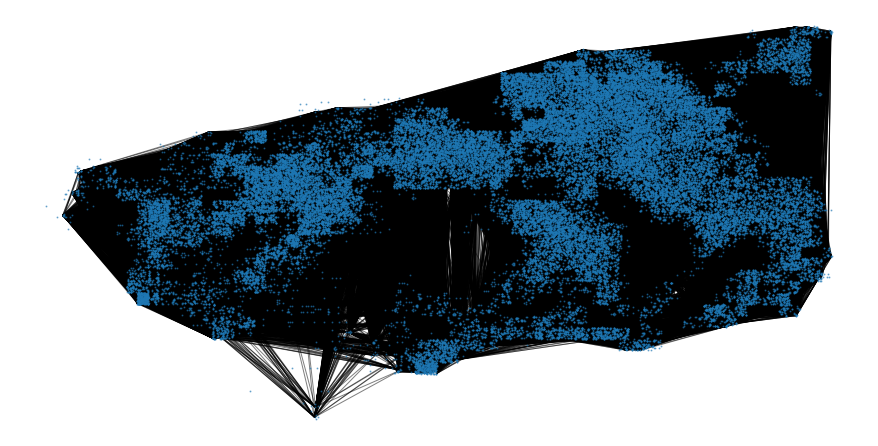

In [57]:
plt.figure(figsize=(12,6))
nx.draw(G_esc, pos=attrib_pos_individuos, node_size=1, alpha=0.5)
plt.show()

---